In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-01 09:23:53.128579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-01 09:23:53.128595: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from LinearModel import LinearModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [5]:
# Initiating the class
deep_learner = LinearModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
# Fitting the model

model = deep_learner.LinearModel()

Epoch 1/10
 1/66 [..............................] - ETA: 7s - loss: 0.0159

2022-03-01 09:23:56.511829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 09:23:56.512313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-01 09:23:56.512364: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-01 09:23:56.512407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-01 09:23:56.512448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

66/66 [==============================] - 0s 1ms/step - loss: 0.0161 - val_loss: 0.0137
Epoch 2/10
66/66 [==============================] - 0s 684us/step - loss: 0.0126 - val_loss: 0.0116
Epoch 3/10
66/66 [==============================] - 0s 680us/step - loss: 0.0107 - val_loss: 0.0102
Epoch 4/10
66/66 [==============================] - 0s 685us/step - loss: 0.0094 - val_loss: 0.0091
Epoch 5/10
66/66 [==============================] - 0s 520us/step - loss: 0.0085 - val_loss: 0.0083
Epoch 6/10
66/66 [==============================] - 0s 734us/step - loss: 0.0078 - val_loss: 0.0077
Epoch 7/10
66/66 [==============================] - 0s 630us/step - loss: 0.0072 - val_loss: 0.0072
Epoch 8/10
66/66 [==============================] - 0s 778us/step - loss: 0.0068 - val_loss: 0.0068
Epoch 9/10
66/66 [==============================] - 0s 733us/step - loss: 0.0064 - val_loss: 0.0064
Epoch 10/10
66/66 [==============================] - 0s 681us/step - loss: 0.0061 - val_loss: 0.0062


In [7]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

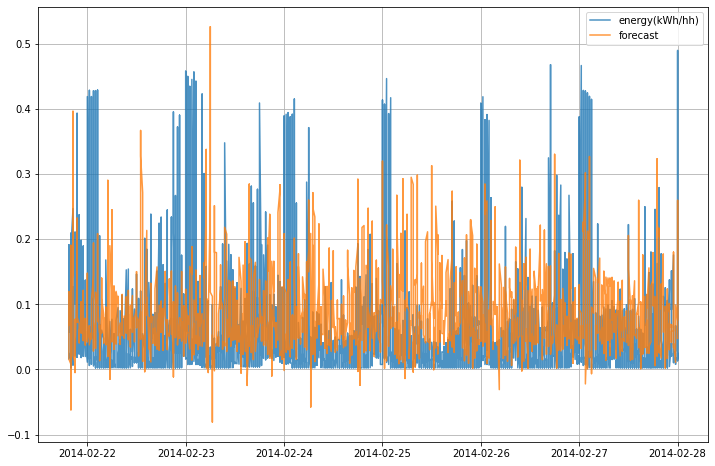

In [9]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_13844/2528746469.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


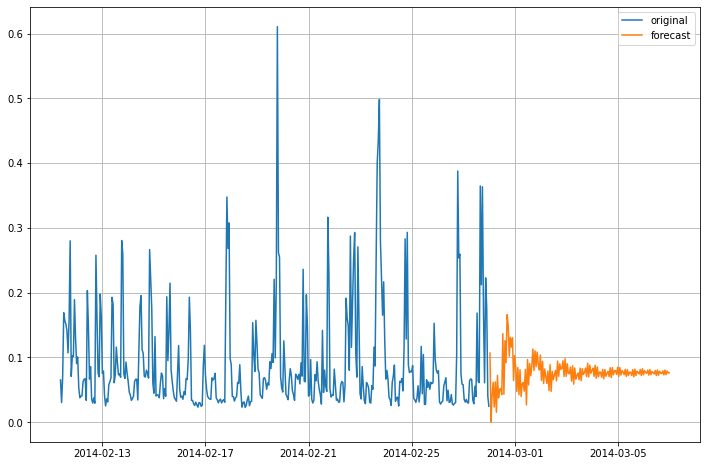

In [10]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [11]:
deep_learner.evaluateMSE()

0.006178940977463585

In [12]:
deep_learner.evaluateRMSE()

0.07860624006695388

In [13]:
deep_learner.evaluateMAE()

0.04915592181132679

In [14]:
deep_learner.evaluateMAPE()

57.64588800321754

In [15]:
yhat =deep_learner.predict()

In [16]:
yhat

[0.067707896,
 0.11915971,
 0.047597494,
 0.037741836,
 0.03502186,
 0.015763763,
 0.007945532,
 0.14021295,
 0.04109443,
 0.10950999,
 0.12107216,
 0.1237458,
 0.08911784,
 -0.06205685,
 0.1903589,
 0.1140466,
 0.15342084,
 0.113778755,
 0.39616615,
 0.32575682,
 0.24639274,
 0.1793781,
 0.13860609,
 0.14003694,
 0.10223684,
 0.020917013,
 0.010510903,
 0.054106757,
 0.048594594,
 0.06642428,
 -0.0047883317,
 0.053633556,
 0.07681702,
 0.06829033,
 0.044949923,
 0.01616684,
 0.14279841,
 0.11597358,
 0.15254436,
 0.10649806,
 0.23217107,
 0.17238359,
 0.07253822,
 0.07312924,
 0.10616125,
 0.08022285,
 0.0701914,
 0.055170856,
 0.06439008,
 0.0626833,
 0.043660562,
 0.04639607,
 0.040778328,
 0.055008743,
 0.048596073,
 0.059673935,
 0.06813747,
 0.085160926,
 0.055943776,
 0.05916689,
 0.09490256,
 0.1037087,
 0.07368559,
 0.07208225,
 0.06404093,
 0.0851754,
 0.07261184,
 0.08511864,
 0.08327703,
 0.076800175,
 0.12127446,
 0.08639258,
 0.08546817,
 0.09964937,
 0.044251047,
 0.0837